In [132]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as opt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os

### Hyperparameters

In [133]:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Get MNIST Data

In [134]:
train_loader = torch.utils.data.DataLoader(
                        datasets.MNIST(
                            root = "digits_data",
                            train = True,
                            download = True,
                            transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize( (0.1307, ), (0.3081, ))
                            ])
                        ),
                batch_size = batch_size_train
            )

test_loader = torch.utils.data.DataLoader(
                        datasets.MNIST(
                            root = "digits_data",
                            train = False,
                            download = True,
                            transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize( (0.1307, ), (0.3081, ) )
                            ])
                       ),
                 batch_size = batch_size_test
            )

### Examine Examples

In [135]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

In [136]:
example_data.shape

torch.Size([1000, 1, 28, 28])

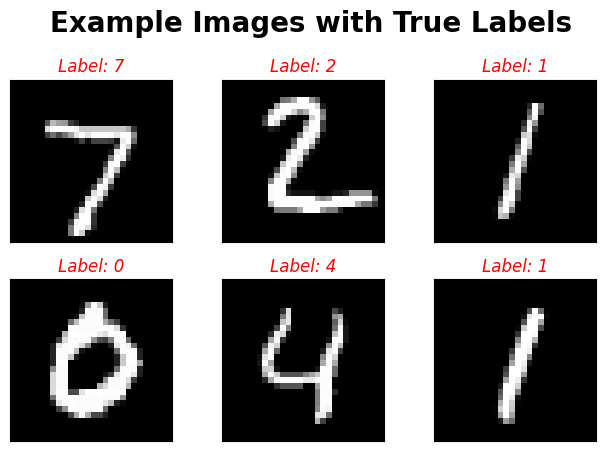

In [137]:
fig = plt.figure()
fig.suptitle("Example Images with True Labels", weight = 'bold', fontsize = 20)
for i in range(6):
    plt.subplot(2,3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap = "gray", interpolation = 'none')
    plt.title(f"Label: {example_target[i]}", color = 'red', style = 'italic')
    plt.xticks([])
    plt.yticks([])

In [138]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # convolution layer with 10 5x5 filters
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)

        # convolution layer with 20 5x5 filters
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)

        # drop layer, rate = 50%
        self.conv2_drop = nn.Dropout2d(p = 0.50)

        # fully connected layer with 50 nodes
        self.fc1 = nn.Linear(320, 50)

        # fully connected later with 10 nodes
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):

        # max pooling with reLU, 2x2
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        # max pooling with reLU 2x2
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))

        # flattening operation
        x = x.view(-1, 320)

        # reLU on output of fully connected layer
        x = F.relu(self.fc1(x))

        # final fully connected later
        x = self.fc2(x)

        # apply log softmax
        return F.log_softmax(x, dim = 1)

### Initialize Neural Network

In [139]:
# instantiate NeuralNetwork
model = NeuralNetwork()

# define optimizer
optimizer = opt.SGD(model.parameters(), lr = learning_rate, momentum = momentum)


In [140]:
def train_loop(dataloader, model, optimizer, train_losses_list, train_accuracy, train_counter_list, epoch):

    # track accuracy
    correct = 0
    total = 0

    # get the size of the data
    size = len(dataloader.dataset)

    # set to training mode
    model.train()

    # iterate over batches
    for batch, (X, y) in enumerate(dataloader):

        # set gradient to zero
        optimizer.zero_grad()

        # compute prediction and loss
        out = model(X)
        loss = F.nll_loss(out, y)

        # get the predicted label
        _, predicted = torch.max(out.data, 1)
        total += y.size(0)
        correct += (predicted == y).sum().item()

        # back propagation
        loss.backward()
        optimizer.step()

        if batch % log_interval == 0:
            print(f'Loss: {loss.item()} [{batch * batch_size_train}/{size}] ({100.0 * batch / len(dataloader)})')

            # update trackers
            train_losses_list.append(loss.item())
            train_counter_list.append(((batch * batch_size_train) + (epoch - 1) * size))
            
            # save network and optimizer
            torch.save(model.state_dict(), "results/model.pth")
            torch.save(optimizer.state_dict(), "results/optimizer.pth")

    # update accuracy
    print(total)
    accuracy = (correct / total) * 100
    train_accuracy.append(accuracy)
    print(f'Train Accuracy: {accuracy}')

In [141]:
def test_loop(dataloader, model, test_accuracy, test_losses):

    # get the size
    size = len(dataloader.dataset)

    # set to evaluate mode
    model.eval()

    # trackers
    test_loss = 0
    correct = 0

    # set to no gradient
    with torch.no_grad():
        for X, y in dataloader:
            output = model(X)
            test_loss += F.nll_loss(output, y, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum()
    test_loss /= size
    test_losses.append(test_loss)
    accuracy = (100 * correct / size)
    test_accuracy.append(accuracy)

    print(f"Test Error: \n \
            Accuracy : {accuracy:>0.1f}% \n \
            Average Loss: {test_loss:>8f}\n")


In [142]:
# tracking containers
train_losses = []
train_counter = []
train_accuracy = []


test_losses = []
test_accuracy = []
test_counter = [n * len(train_loader.dataset) for n in range(n_epochs + 1)]

In [143]:
test_loop(test_loader, model, test_accuracy, test_losses)

for epoch in range(1, n_epochs + 1):
  print(f'Epoch {epoch} \n ---------------------------------------')
  train_loop(train_loader, model, optimizer, train_losses, train_accuracy, train_counter, epoch)
  test_loop(test_loader, model, test_accuracy, test_losses)

/Users/nelsonfarrell/miniconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test Error: 
             Accuracy : 11.0% 
             Average Loss: 2.306498

Epoch 1 
 ---------------------------------------
Loss: 2.305110216140747 [0/60000] (0.0)
Loss: 2.3162429332733154 [640/60000] (1.0660980810234542)
Loss: 2.289057731628418 [1280/60000] (2.1321961620469083)
Loss: 2.2587947845458984 [1920/60000] (3.1982942430703623)
Loss: 2.258589029312134 [2560/60000] (4.264392324093817)
Loss: 2.2110304832458496 [3200/60000] (5.330490405117271)
Loss: 2.19580078125 [3840/60000] (6.3965884861407245)
Loss: 2.1443772315979004 [4480/60000] (7.462686567164179)
Loss: 2.059699535369873 [5120/60000] (8.528784648187633)
Loss: 1.9799816608428955 [5760/60000] (9.594882729211088)
Loss: 1.7635606527328491 [6400/60000] (10.660980810234541)
Loss: 1.5840928554534912 [7040/60000] (11.727078891257996)
Loss: 1.2945785522460938 [7680/60000] (12.793176972281449)
Loss: 1.1104952096939087 [8320/60000] (13.859275053304904)
Loss: 0.9412065744400024 [8960/60000] (14.925373134328359)
Loss: 0.812226176

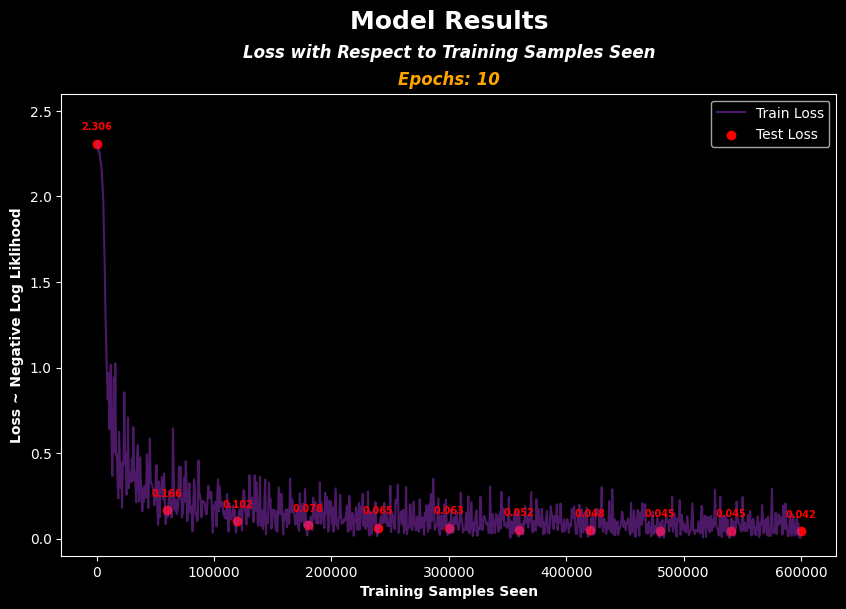

In [14]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize = (10, 6))
    plt.plot(train_counter, train_losses, color = 'darkorchid', alpha = .5)
    plt.scatter(test_counter, test_losses, color = 'red')
    for x, y in zip(test_counter, test_losses):
        plt.annotate(f'{y:.3f}',
                     (x, y), 
                     textcoords = "offset points", 
                     xytext = (0, 10), 
                     ha = 'center',
                     color = 'red',
                     fontsize = 7,
                     weight = 'bold') 
    plt.ylim((-.1, 2.6))
    plt.legend(['Train Loss', 'Test Loss'], loc = 'upper right')
    plt.xlabel('Training Samples Seen', weight = 'bold')
    plt.ylabel('Loss ~ Negative Log Liklihood', weight = 'bold')
    plt.text(0.5, 1.13, 
            'Model Results', 
            fontsize = 18, 
            ha='center', 
            va='bottom', 
            transform = plt.gca().transAxes, 
            weight = 'bold')
    plt.text(0.5, 1.07, 
            'Loss with Respect to Training Samples Seen', 
            fontsize = 12, 
            ha = 'center', 
            va = 'bottom', 
            transform = plt.gca().transAxes, 
            weight = 'bold',
            style = 'italic')
    plt.text(0.5, 1.01, 
            f'Epochs: {n_epochs}', 
            fontsize = 12, 
            ha = 'center', 
            va = 'bottom', 
            transform = plt.gca().transAxes, 
            weight = 'bold',
            style = 'italic',
            color = 'orange');

In [15]:
test_accuracy_list = [t.item() for t in test_accuracy]


In [145]:
train_accuracy

[80.07666666666667,
 93.92,
 95.255,
 96.09833333333333,
 96.54333333333334,
 96.85000000000001,
 97.05333333333334,
 97.27833333333334,
 97.53333333333333,
 97.565,
 97.71333333333332,
 97.77666666666667,
 97.93166666666666,
 97.97,
 98.085,
 98.10333333333332,
 98.16166666666668,
 98.14500000000001,
 98.28833333333333,
 98.28333333333333]

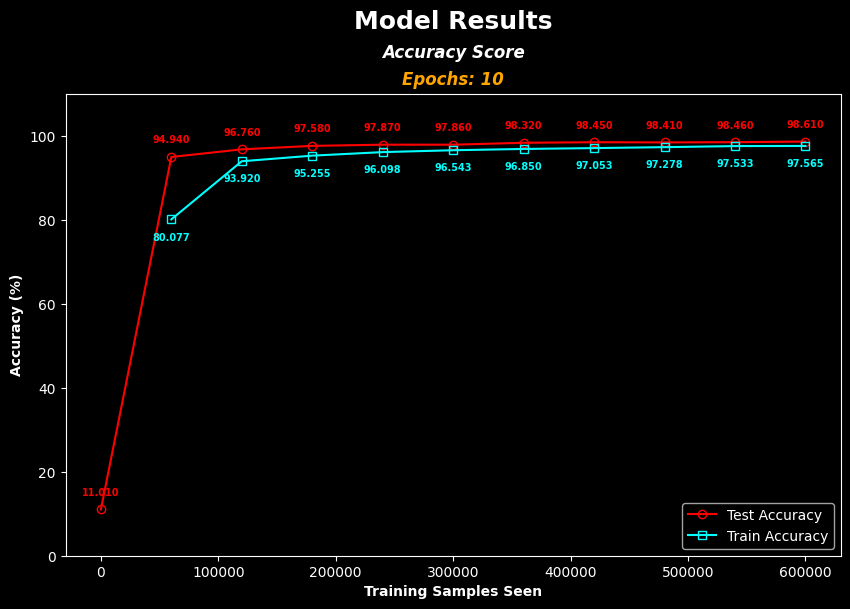

In [17]:
with plt.style.context('dark_background'):
    fig = plt.figure(figsize = (10, 6))
    plt.plot(test_counter, test_accuracy_list, marker = "o", mfc = 'none', color = 'red')
    plt.plot(test_counter[1:], train_accuracy, marker = "s", mfc = 'none', color = 'cyan')
    for x, y in zip(test_counter, test_accuracy_list):
        plt.annotate(f'{y:.3f}',
                     (x, y), 
                     textcoords = "offset points", 
                     xytext = (0, 10), 
                     ha = 'center',
                     color = 'red',
                     fontsize = 7,
                     weight = 'bold')
    for x, y in zip(test_counter[1:], train_accuracy):
        plt.annotate(f'{y:.3f}',
                     (x, y), 
                     textcoords = "offset points", 
                     xytext = (0, -15), 
                     ha = 'center',
                     color = 'cyan',
                     fontsize = 7,
                     weight = 'bold') 
    plt.legend(['Test Accuracy', 'Train Accuracy'], loc = 'lower right')
    plt.xlabel('Training Samples Seen', weight = 'bold')
    plt.ylabel('Accuracy (%)', weight = 'bold')
    plt.text(0.5, 1.13, 
            'Model Results', 
            fontsize = 18, 
            ha='center', 
            va='bottom', 
            transform = plt.gca().transAxes, 
            weight = 'bold')
    plt.text(0.5, 1.07, 
            'Accuracy Score', 
            fontsize = 12, 
            ha = 'center', 
            va = 'bottom', 
            transform = plt.gca().transAxes, 
            weight = 'bold',
            style = 'italic')
    plt.text(0.5, 1.01, 
            f'Epochs: {n_epochs}', 
            fontsize = 12, 
            ha = 'center', 
            va = 'bottom', 
            transform = plt.gca().transAxes, 
            weight = 'bold',
            style = 'italic',
            color = 'orange');
    plt.ylim(0, 110)

In [18]:
# insantiate model and optimizer
model_conti = NeuralNetwork()
continued_optimizer = opt.SGD(model.parameters(), lr = learning_rate, momentum = momentum)

In [19]:
# load saved model and optimizer 
model_conti.load_state_dict(torch.load('results/model.pth'))
continued_optimizer.load_state_dict(torch.load('results/optimizer.pth'))

In [20]:
# set model to evaluation mode
model_conti.eval()

# containers for plots
true_labels = []
predicted_labels = []
probas = []

# tracker
t = 0

# iterate over first 10 images in test_loader
for images, labels in test_loader:
    for i in range(len(images)):

        # set to no gradient
        with torch.no_grad():
            output = model_conti(images[i])
            print('*' * 50)
            print(f'Actual Class: {labels[i]}')
            probabilities = torch.softmax(output, dim = 1)
            predicted_class = torch.argmax(probabilities, dim = 1)
            print(f"Predicted class (index): {predicted_class.item()}")
            print(f'Class Probabilities: {output[0]}')

            # update containers
            true_labels.append(labels[i])
            predicted_labels.append(predicted_class.item())
            probas.append(output[0])
        
        # update tracker
        t += 1

        # end inner loop
        if t == 10:
            break
     # outer loop   
    if t == 10:
        break

**************************************************
Actual Class: 7
Predicted class (index): 7
Class Probabilities: tensor([-1.9340e+01, -2.2775e+01, -1.2433e+01, -1.2228e+01, -2.8024e+01,
        -1.9783e+01, -3.5567e+01, -9.1791e-06, -1.6406e+01, -1.5287e+01])
**************************************************
Actual Class: 2
Predicted class (index): 2
Class Probabilities: tensor([-1.1189e+01, -1.1650e+01, -2.3007e-05, -1.9343e+01, -2.0232e+01,
        -2.6281e+01, -1.8283e+01, -1.6252e+01, -1.5013e+01, -3.0103e+01])
**************************************************
Actual Class: 1
Predicted class (index): 1
Class Probabilities: tensor([-1.4341e+01, -9.3575e-05, -1.1502e+01, -1.7957e+01, -1.0377e+01,
        -1.8125e+01, -1.6667e+01, -9.9283e+00, -1.2763e+01, -1.6059e+01])
**************************************************
Actual Class: 0
Predicted class (index): 0
Class Probabilities: tensor([-2.0266e-06, -2.6888e+01, -1.5065e+01, -2.0729e+01, -2.3081e+01,
        -1.6806e+01, -1.38

/Users/nelsonfarrell/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:1354: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

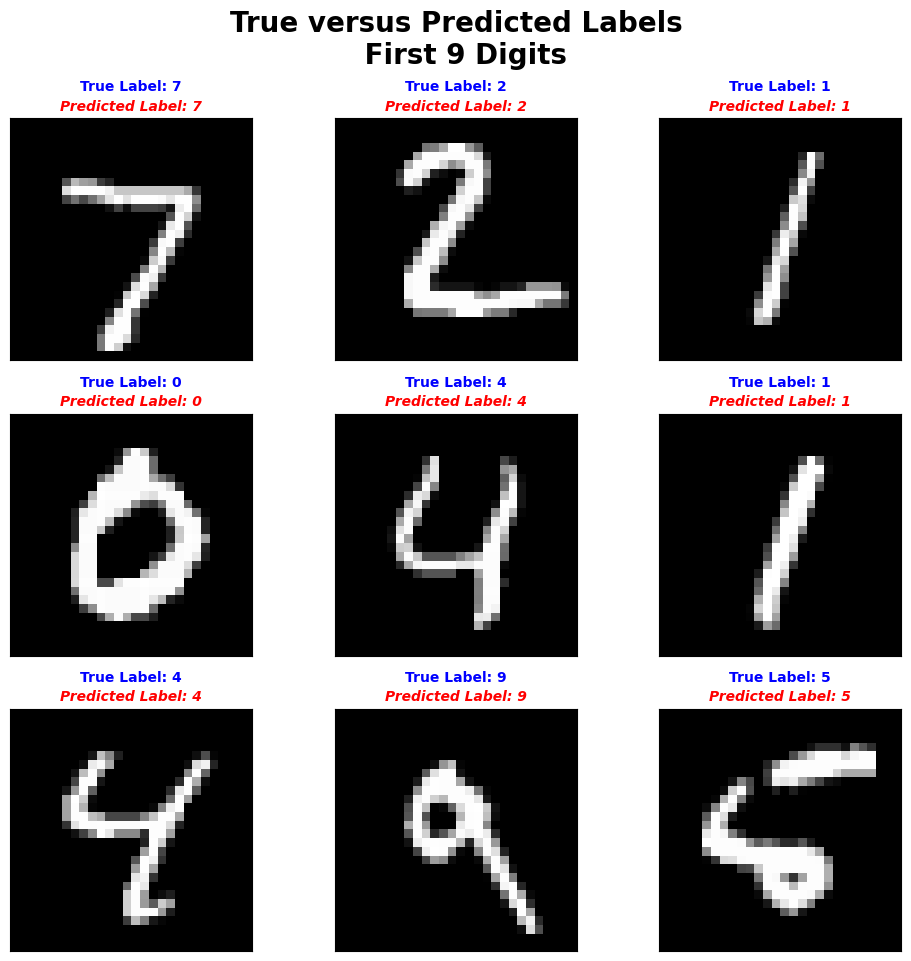

In [22]:
fig = plt.figure(figsize = (10, 10))
fig.suptitle(f'True versus Predicted Labels \n First 9 Digits', weight = "bold", fontsize = 20)
for i in range(9):
    plt.subplot(3,3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap = "gray", interpolation = 'none')
    plt.text(0.5, 1.10, 
        f'True Label: {true_labels[i]}', 
        fontsize = 10, 
        ha='center', 
        va='bottom', 
        transform = plt.gca().transAxes,
        color = 'blue',
        weight = 'bold')
    plt.text(0.5, 1.02, 
        f'Predicted Label: {predicted_labels[i]}', 
        fontsize = 10, 
        ha = 'center', 
        va = 'bottom', 
        transform = plt.gca().transAxes,
        color = "red",
        weight = 'bold',
        style = 'italic')
    plt.xticks([])
    plt.yticks([])



In [123]:
import cv2

# folder containing original imagesimages
raw_image_folder = '/Users/nelsonfarrell/Documents/Northeastern/5330/problem_sets/problem_set_5/digits_homebrew_raw'  

# output folder for modified images
curated_image_folder = '/Users/nelsonfarrell/Documents/Northeastern/5330/problem_sets/problem_set_5/digits_homebrew_curated'

# iterate over the image files in the image folder
for file_name in os.listdir(raw_image_folder):

    # make sure it's an image
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):

        # set image path
        image_path = os.path.join(raw_image_folder, file_name)

        # read in the image
        image = cv2.imread(image_path)

        # convert to greyscale
        grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # resize image
        resized_image = cv2.resize(grey_image, (28, 28))

        # invert the image colors
        inverted_img = cv2.bitwise_not(resized_image)

        # process images
        processed_img = np.where(inverted_img > 127, inverted_img, 0)

        # rotate the image
        binary_img = cv2.rotate(processed_img, cv2.ROTATE_90_CLOCKWISE)

        # set output
        out = os.path.join(curated_image_folder, file_name)

        # save new image
        cv2.imwrite(out, binary_img)

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


In [127]:
 # output folder for modified images
curated_image_folder = '/Users/nelsonfarrell/Documents/Northeastern/5330/problem_sets/problem_set_5/digits_homebrew_curated'

# image list
image_list = []
true_label_list = []

# iterate over the image files in the image folder
for file_name in os.listdir(curated_image_folder):

    # make sure it's an image
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):

        # true label string
        label, _ = file_name.split('.')

        # capitalize_label
        label = label.capitalize()

        # set image path
        image_path = os.path.join(curated_image_folder, file_name)

        # read in the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        print(image.shape)

        # update lists
        true_label_list.append(label)
        image_list.append(image)

        # get the globel mean and std
        all_images = np.stack(image_list)

        # mean
        mean = np.mean(all_images)
        std = np.std(all_images)

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


In [129]:
print(mean)
print(std)

37.1202806122449
82.55771912217507


In [144]:
predicted_labels = []
for i, j in zip(image_list, true_label_list):
    i = (i - mean)/std
    tensor_image = torch.tensor(i, dtype = torch.float32)
    tensor_image = tensor_image.unsqueeze(0)

    # set to no gradient
    with torch.no_grad():
        output = model_conti(tensor_image)
        print('*' * 50)
        probabilities = torch.softmax(output, dim = 1)
        predicted_class = torch.argmax(probabilities, dim = 1)
        predicted_label = predicted_class.item()
        predicted_labels.append(predicted_label)
        print(f"True Class: {j}")
        print(f"Predicted class (index): {predicted_label}")
        print(f'Class Probabilities: {output[0]}')

**************************************************
True Class: Three
Predicted class (index): 3
Class Probabilities: tensor([ -8.0446, -11.9392,  -4.8700,  -0.1815, -17.3290,  -5.4656, -14.1737,
         -1.9540,  -4.4207, -11.1563])
**************************************************
True Class: Two
Predicted class (index): 7
Class Probabilities: tensor([-12.4515,  -3.3551,  -5.0912,  -7.4012, -12.3315, -12.9775, -23.2846,
         -0.0558,  -8.1407,  -4.4010])
**************************************************
True Class: Six
Predicted class (index): 7
Class Probabilities: tensor([ -8.1982,  -1.2596,  -1.8080,  -6.5549,  -3.4275, -10.4708, -10.9965,
         -0.6610,  -6.7586,  -7.5052])
**************************************************
True Class: Four
Predicted class (index): 4
Class Probabilities: tensor([-19.4319, -13.7006, -11.3327,  -2.5127,  -0.0852,  -9.0738, -17.1542,
        -13.7830,  -7.9714,  -8.7731])
**************************************************
True Class: Zero
P

/Users/nelsonfarrell/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:1354: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


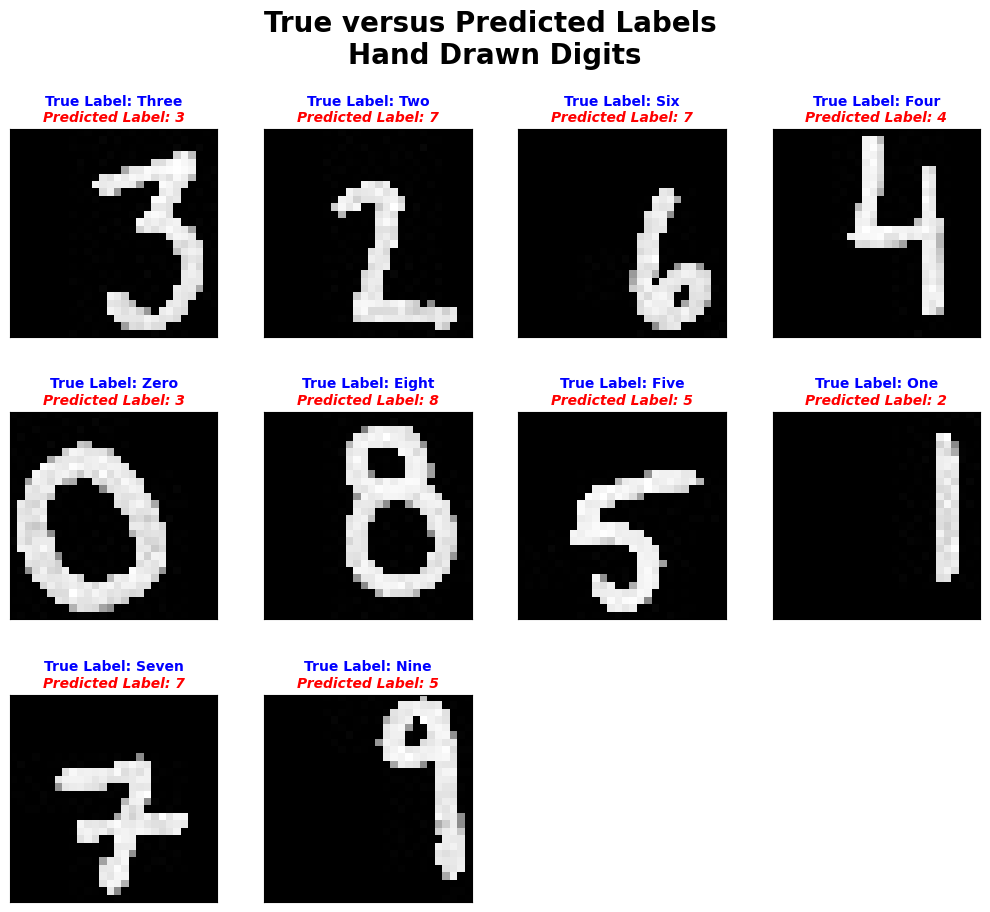

In [131]:
fig = plt.figure(figsize = (10, 10))
fig.suptitle(f'True versus Predicted Labels \nHand Drawn Digits', weight = "bold", fontsize = 20)
for i in range(len(image_list)):
    plt.subplot(3,4, i + 1)
    plt.tight_layout()
    plt.imshow(image_list[i], cmap = "gray", interpolation = 'none')
    plt.text(0.5, 1.10, 
        f'True Label: {true_label_list[i]}', 
        fontsize = 10, 
        ha='center', 
        va='bottom', 
        transform = plt.gca().transAxes,
        color = 'blue',
        weight = 'bold')
    plt.text(0.5, 1.02, 
        f'Predicted Label: {predicted_labels[i]}', 
        fontsize = 10, 
        ha = 'center', 
        va = 'bottom', 
        transform = plt.gca().transAxes,
        color = "red",
        weight = 'bold',
        style = 'italic')
    plt.xticks([])
    plt.yticks([])